# Домашняя работа

1. Решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

In [1]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns

%matplotlib inline

In [37]:
import pandas as pd
data = pd.read_csv('train.csv')

In [38]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


теперь обработаем наши данные зашифровав текстовые показатели

In [39]:
from sklearn.preprocessing import LabelEncoder

int_columns = []
object_columns = []
for name_columns in data.columns:
    data[name_columns].fillna('zero', inplace = True) # заменим 
    if  str(data[name_columns].dtype)=='int64':
        int_columns.append(name_columns)
    if  str(data[name_columns].dtype)=='int32':
        int_columns.append(name_columns)        
    try:
        if  str(data[name_columns].dtype)=='object': # зашифруем текстовые значения        
            object_columns.append(name_columns)
            le.fit(data[name_columns])
            data[name_columns] = le.transform(data[name_columns])
    except:
        pass
data = data[int_columns] # оставим только численные столбцы

разделит выборку на X y

In [40]:
y_data = data['SalePrice']
X_data = data.drop('SalePrice', axis=1)

теперь X y, делим на Train Test

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3)

нормализуем наши данные

In [43]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,10))

np_scaled = min_max_scaler.fit_transform(X_train[int_columns])
X_train_norm = pd.DataFrame(np_scaled)
X_train_norm.columns = [int_columns]
X_train_norm.head()

np_scaled = min_max_scaler.fit_transform(X_test[int_columns])
X_test_norm = pd.DataFrame(np_scaled)
X_test_norm.columns = [int_columns]
X_test_norm.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,6.009615,0.000000,2.091126,3.333333,4.285714,6.434109,2.166667,1.121545,0.0,2.425436,...,4.569817,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,2.5
1,8.873626,2.352941,0.758121,6.666667,4.285714,7.441860,4.333333,0.343728,0.0,3.590321,...,3.723554,0.0,0.511883,0.000000,0.0,5.395833,0.0,0.0,1.818182,0.0
2,2.541209,1.764706,1.372433,3.333333,2.857143,6.124031,1.500000,0.000000,0.0,0.000000,...,4.795487,0.0,1.078611,0.000000,0.0,0.000000,0.0,0.0,5.454545,5.0
3,9.491758,0.588235,2.095790,4.444444,7.142857,2.945736,9.500000,0.000000,0.0,4.592009,...,4.062059,0.0,0.000000,2.901554,0.0,0.000000,0.0,0.0,6.363636,2.5
4,5.625000,2.352941,0.501659,6.666667,4.285714,9.534884,8.833333,0.000000,0.0,4.490715,...,4.196051,0.0,0.822669,0.000000,0.0,0.000000,0.0,0.0,4.545455,5.0


обучаем модель бэггинга для регрессии

In [49]:
from sklearn.ensemble import BaggingRegressor

bag_reg = BaggingRegressor(n_estimators=20, n_jobs=-1)
bag_reg.fit(X_train_norm, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=20, n_jobs=-1,
                 oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [173]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

bag_reg = BaggingRegressor(n_estimators=50, n_jobs=-1)
bag_reg.fit(X_train_norm, y_train)
def lin_reg(x_test, y_test, model): # функция которая помогает оценить качество обученной модели линейной регрессии
    R = model.score(x_test, y_test) # смотрим наш R^2
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    ans = f"R^2 = {R} mse = {mse}"
    return ans 
lin_reg(X_test_norm, y_test, bag_reg)

'R^2 = 0.7714409672720084 mse = 1548306044.0567737'

In [105]:
ln_model = LinearRegression()
ln_model.fit(X_train_norm, y_train)
lin_reg(X_test_norm, y_test, ln_model)
lin_reg(X_test_norm, y_test, ln_model)

' R^2 = 0.7098221396380012 mse = 1965724695.661618'

In [214]:
from sklearn.ensemble import RandomForestRegressor

reg_rf = RandomForestRegressor(n_estimators=50, n_jobs=-1)
reg_rf.fit(X_train_norm, y_train)
lin_reg(X_test_norm, y_test, reg_rf)

'R^2 = 0.7716489694570308 mse = 1546896994.3403683'

как видим модель регрессионного беггинга и случайного леса, дают примерно одинаковые показатели
, но каждая из них лучше просто линейной регрессии примерно на 5-7%

Выводим важность признаков для случайного леса

In [224]:
impotancse = pd.DataFrame(int_columns)
impotancse['coeff'] = pd.DataFrame(reg_rf.feature_importances_)
impotancse.sort_values(by=['coeff'], ascending=False).head()

,0,coeff
3,OverallQual,0.599496
14,GrLivArea,0.099223
12,2ndFlrSF,0.041016
10,TotalBsmtSF,0.034285
11,1stFlrSF,0.033724


In [240]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

In [242]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=555)

meta_train = []
meta_test = []
col_names = []

print('bag features...')
meta_tr, meta_te = get_meta_features(bag_reg, X_train_norm, y_train, X_test_norm, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('bag_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(reg_rf, X_train_norm, y_train, X_test_norm, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

bag features...


c:\users\sladk\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


RF features...


c:\users\sladk\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [244]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

In [255]:
reg_rf = RandomForestRegressor(n_estimators=30, n_jobs=-1)
reg_rf.fit(X_meta_train, y_train)
lin_reg(X_meta_test, y_test, reg_rf)

'R^2 = 0.6954106397934322 mse = 2063351168.9930162'

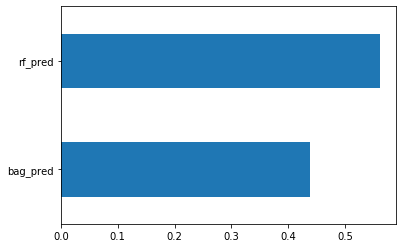

In [257]:
pd.Series(reg_rf.feature_importances_, index=X_meta_train.columns).plot(kind='barh')

для линейной регрессии, такой алгоритм, дал худшие результаты, чем даже просто линейная регрессия, без всяких заморочек.
в итоге для линейной регресии лучше всего использовать либо лес решений либо бэггинг